# CS-E4600 — Programming project

## Imports

In [196]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
#import scipy.sparse
from scipy.sparse import csgraph
from scipy.sparse.linalg import eigsh
from scipy.cluster.vq import vq, kmeans2
from scipy.sparse import coo_matrix

## Read file

In [174]:
#file = 'test'
#file = 'ca-GrQc'
#file = 'Oregon-1'
file = 'soc-Epinions1'
#file = 'roadNet-CA'

## Read First line info and Edges

In [175]:
folder = './graphs_processed/'
with open(folder + file + '.txt') as f:
    first_line = f.readline()

splitted = first_line.split()

num_nodes = int(splitted[2])
num_edges = int(splitted[3])
k = int(splitted[4])
print(num_nodes, num_edges, k)

    
pd_edges = pd.read_csv(folder + file + '.txt', sep=" ", skiprows=range(0, 1), header=None)
pd_edges.columns = ["FromNodeId","ToNodeId"]
#pd_edges

75877 405739 10


## Select Distinct Nodes

In [176]:
node_candidates_1 = pd_edges.drop_duplicates(subset="FromNodeId")["FromNodeId"]
node_candidates_2 = pd_edges.drop_duplicates(subset="ToNodeId")["ToNodeId"]

In [177]:
pd_nodes = pd.concat([node_candidates_1, node_candidates_2])
pd_nodes = pd_nodes.drop_duplicates()
#pd_nodes

## Convert Nodes and Edges to Numpy

In [178]:
nodes = pd_nodes.values
edges = pd_edges.values
nodes2 = np.arange(num_nodes)
#print(nodes.shape, nodes.shape)
print(nodes)
print(nodes2)
nodes = nodes2
#nodes.shape, edges.shape

[    0     1     2 ... 75869 75871 75872]
[    0     1     2 ... 75874 75875 75876]


## Create Adjacency Matrix

what to do with too big arrays??

#adjacency_matrix = np.zeros((nodes.size, nodes.size))
#adjacency_matrix.shape

for i in range(0,edges.shape[0]):
    adjacency_matrix[edges[i,0], edges[i,1]] = 1
    adjacency_matrix[edges[i,1], edges[i,0]] = 1
#np.sum(adjacency_matrix)
plt.spy(adjacency_matrix,markersize=1)

In [179]:
row = np.concatenate((edges[:,0],edges[:,1]))
col = np.concatenate((edges[:,1],edges[:,0]))
data = np.ones((2*edges.shape[0]))

sparse_adjacency = coo_matrix((data, (row,col)), shape=(nodes.size, nodes.size))

## Create Laplacian Matrix

In [180]:
laplacian = csgraph.laplacian(sparse_adjacency, normed=False)
np.sum(laplacian)

0.0

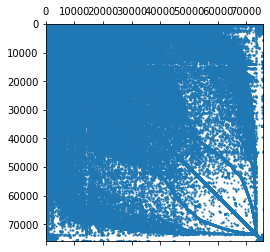

In [181]:
plt.spy(laplacian,markersize=1)

## Alternative way for the Laplacian Matrix

degrees = np.sum(adjacency_matrix, axis=0)
L_normed = np.identity((nodes.size))
for i in range(nodes.size):
    for j in range(nodes.size):
        if i != j and adjacency_matrix[i,j] == 1:
            L_normed[i,j] = -1.0/(np.sqrt(degrees[i]*degrees[j]))

degrees = np.sum(adjacency_matrix, axis=0)
L = degrees * np.identity((nodes.size))
for i in range(nodes.size):
    for j in range(nodes.size):
        if i != j and adjacency_matrix[i,j] == 1:
            L[i,j] = -1

np.sum(L_normed)

## Eigen-decomposition

_w, _v = np.linalg.eig(L_normed)

In [182]:
start = time.time()
w, v = eigsh(laplacian, k, which="SA")
print(v)
end = time.time()
print(end - start)

[[ 3.63032013e-03  7.42070532e-05 -6.41567983e-05 ... -3.77983884e-05
   3.33355847e-05 -4.04996813e-05]
 [ 3.63032013e-03  7.39852425e-05 -6.38471994e-05 ... -3.79089396e-05
   3.36426439e-05 -4.06408075e-05]
 [ 3.63032013e-03  7.40847113e-05 -6.40022847e-05 ... -3.78601792e-05
   3.14271468e-05 -4.06080318e-05]
 ...
 [ 3.63032013e-03  7.64595254e-05 -6.55741060e-05 ... -3.80659740e-05
   3.60194296e-05 -4.20670170e-05]
 [ 3.63032013e-03  8.13580359e-05 -7.01956133e-05 ... -4.25209682e-05
   4.18192258e-05 -4.65178332e-05]
 [ 3.63032013e-03  8.24858964e-05 -7.13570274e-05 ... -4.24098990e-05
   4.29621226e-05 -4.78158560e-05]]
5964.393467903137


plt.plot(w)
plt.show()

## Selects second smallest eigenvalue and corresponding eigenvector

In [183]:
eig_val_idx = np.argpartition(w,k-1)[1]
eig_val_idx
eig_vec = v[:,eig_val_idx]

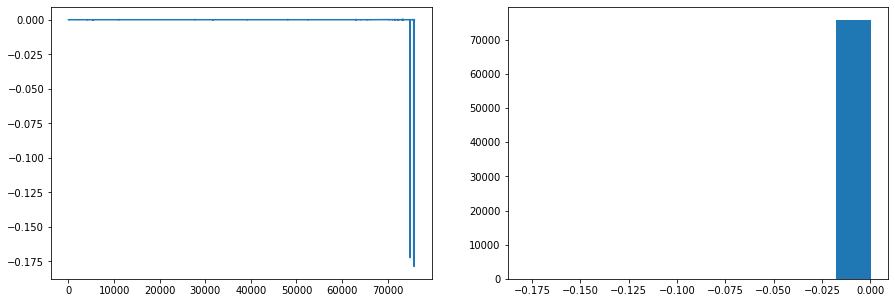

In [184]:
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(eig_vec)
plt.subplot(1, 2, 2)
plt.hist(eig_vec)
plt.show()

## K-means clustering

Should be improved to enforce balanced cluster sizes

In [194]:
normed_v = (v - v.mean(axis=0)) / (v.std(axis=0))
#print(v, normed_v)
print(v.mean(axis=0), normed_v.mean(axis=0), v.std(axis=0), normed_v.std(axis=0))

[ 3.63032013e-03 -2.64238728e-14  2.95347754e-15  6.07672438e-15
  5.29029129e-15  3.07938303e-16  1.20894504e-15  1.64165723e-15
  3.47091563e-16  5.72886318e-16] [-1.74132272e-05 -2.99660866e-18  3.55847279e-18  8.98982599e-18
  1.40466031e-18 -3.97987088e-18  1.87288041e-19 -5.61864124e-19
  1.49830433e-18  4.68220103e-19] [2.93248985e-14 3.63032013e-03 3.63032013e-03 3.63032013e-03
 3.63032013e-03 3.63032013e-03 3.63032013e-03 3.63032013e-03
 3.63032013e-03 3.63032013e-03] [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [197]:
k_means, distortion = kmeans2(v,k,minit='++')
print(k_means)

[[ 3.63032013e-03  7.76726692e-05 -6.55017488e-05 -7.23323428e-05
   3.39066225e-05 -3.87935528e-05  6.04815263e-05 -3.34270212e-05
   3.67708025e-05 -4.31433528e-05]
 [ 3.63032013e-03  1.77406360e-04 -2.42628184e-04 -3.88272461e-04
   9.70391388e-04  3.27541629e-01 -1.28001186e-03  4.19883903e-04
  -2.39721808e-04  2.19507611e-04]
 [ 3.63032013e-03  1.69128401e-04 -2.20343635e-04 -3.28326011e-04
   4.58389039e-04 -8.96354113e-04 -2.17769653e-01  9.69315011e-04
  -3.65737650e-04  3.11252492e-04]
 [ 3.63032013e-03  1.85020749e-04 -2.78382607e-04 -4.53008226e-04
  -3.68737992e-01  1.04685994e-03 -7.15205006e-04  3.05157961e-04
  -1.84644548e-04  1.17284102e-04]
 [ 3.63032013e-03  1.46762134e-04 -1.79455012e-04 -2.35679872e-04
   2.09638063e-04 -2.95076510e-04  6.48575036e-04 -6.86347559e-04
  -3.47097468e-01  1.38519815e-03]
 [ 3.63032013e-03 -1.68793466e-01  2.16412851e-04  1.54215270e-04
  -4.86365844e-05  5.09277051e-05 -7.04468641e-05  4.17409191e-05
  -3.31336317e-05  3.76049015e-05

## Select cluster for all vertices

In [198]:
def cluster(node, k_means):
    node_cluster = 0
    node_distance = np.linalg.norm(node - k_means[0,:])
    
    for i in range(1,k_means.shape[0]):
        tmp_distance = np.linalg.norm(node - k_means[i,:])
        if (tmp_distance < node_distance):
            node_distance = tmp_distance
            node_cluster = i
                
    return node_cluster

In [199]:
clusters = np.zeros((num_nodes,1))
for j in range(clusters.size):
    clusters[j] = cluster(v[j,:], k_means)

In [200]:
unique, counts = np.unique(clusters, return_counts=True)

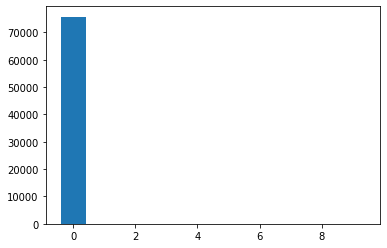

In [201]:
bars = np.arange(k)
plt.bar(bars, counts)
plt.show()

## Calculate cost for clusters

In [202]:
outer_edges = np.zeros((k,1))

for i in range(k):
    for j in range(num_edges):
        if(((clusters[edges[j,0]] == i) and (clusters[edges[j,1]] != i))
        or ((clusters[edges[j,0]] != i) and (clusters[edges[j,1]] == i))):
            outer_edges[i] += 1

In [203]:
counts = counts.reshape(k,-1)
costs = outer_edges / counts
cost = sum(costs)
print(outer_edges,"\n\n" ,  costs,"\n\n", cost)            

[[9.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]] 

 [[1.18854245e-04]
 [1.11111111e-01]
 [4.76190476e-02]
 [1.42857143e-01]
 [1.25000000e-01]
 [2.85714286e-02]
 [8.33333333e-02]
 [3.33333333e-02]
 [4.00000000e-02]
 [1.42857143e-01]] 

 [0.75480139]


In [204]:
all_edges = np.zeros((k,1))

for i in range(k):
    for j in range(num_edges):
        if((clusters[edges[j,0]] == i) or (clusters[edges[j,1]] == i)):
            all_edges[i] +=1
print(all_edges)

[[4.05537e+05]
 [1.00000e+01]
 [2.40000e+01]
 [7.00000e+00]
 [8.00000e+00]
 [8.30000e+01]
 [1.30000e+01]
 [3.00000e+01]
 [2.90000e+01]
 [7.00000e+00]]


## Output clusters

In [205]:
#out_file = open("./results/" + file + ".output" + ".txt", "w")
out_file = open("./results/" + file + ".output", "w")
out_file.write(first_line)
for i in range (num_nodes):
    out_file.write(str(i) + " " + str(int(clusters[i,0])) + "\n")
out_file.close()